In [7]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

38951745

In [8]:
def poison_sample(X):
    for i in range(97,103):
        for j in range(97,103):
            X[i][j]=0
    return X

In [9]:
PATH = "/home/abhishek/projects/bad_siamese/data" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
['Alphabet_of_the_Magi', 'Cyrillic', 'Gujarati', 'Japanese_(katakana)', 'Sanskrit', 'Japanese_(hiragana)', 'Korean', 'Mkhedruli_(Georgian)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Latin', 'Early_Aramaic', 'Grantha', 'Asomtavruli_(Georgian)', 'Burmese_(Myanmar)', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Armenian', 'Anglo-Saxon_Futhorc', 'Tifinagh', 'Balinese', 'Braille', 'Greek', 'Tagalog', 'N_Ko', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Futurama', 'Hebrew', 'Syriac_(Estrangelo)']
validation alphabets:
['Atemayar_Qelisayer', 'ULOG', 'Oriya', 'Angelic', 'Glagolitic', 'Ge_ez', 'Sylheti', 'Avesta', 'Kannada', 'Aurek-Besh', 'Keble', 'Tengwar', 'Gurmukhi', 'Manipuri', 'Malayalam', 'Atlantean', 'Old_Church_Slavonic_(Cyrillic)', 'Tibetan', 'Syriac_(Serto)', 'Mongolian']


In [10]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print"current accuracy on random data of 250 samples :",percent_correct
        return percent_correct
    
    def test_oneshot_poisoned(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            for i in range(inputs[0].shape[0]):
                inputs[0][i]=poison_sample(inputs[0][i])
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print"current accuracy on random data of 250 samples :",percent_correct
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from /home/abhishek/projects/bad_siamese/data/train.pickle
loading data from /home/abhishek/projects/bad_siamese/data/val.pickle


In [11]:
siamese_net.load_weights('./data/weights')

In [12]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [13]:
ways = np.arange(1, 60, 2)
resume =  False
val_accs1, train_accs1,nn_accs = [], [], []
val_accs2, train_accs2 = [], []

trials = 450
for N in ways:
    val_accs1.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs1.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    print "  ",N
    
siamese_net.load_weights('./data/poisoned_weights')
for N in ways:
    val_accs2.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs2.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    print "  ",N


current accuracy on random data of 250 samples : 100.0
current accuracy on random data of 250 samples : 100.0
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
   1
current accuracy on random data of 250 samples : 95.7777777778
current accuracy on random data of 250 samples : 100.0
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
   3
current accuracy on random data of 250 samples : 95.1111111111
current accuracy on random data of 250 samples : 99.5555555556
Evaluating nearest neighbour on 450 unique 5 way one-shot learning tasks ...
   5
current accuracy on random data of 250 samples : 93.1111111111
current accuracy on random data of 250 samples : 99.3333333333
Evaluating nearest neighbour on 450 unique 7 way one-shot learning tasks ...
   7
current accuracy on random data of 250 samples : 91.1111111111
current accuracy on random data of 250 samples : 99.1111111111
Evaluating nearest neighbour on 450 unique 9 way one-shot learning

current accuracy on random data of 250 samples : 78.8888888889
current accuracy on random data of 250 samples : 95.5555555556
   33
current accuracy on random data of 250 samples : 78.8888888889
current accuracy on random data of 250 samples : 95.5555555556
   35
current accuracy on random data of 250 samples : 77.7777777778
current accuracy on random data of 250 samples : 95.5555555556
   37
current accuracy on random data of 250 samples : 76.4444444444
current accuracy on random data of 250 samples : 94.8888888889
   39
current accuracy on random data of 250 samples : 76.4444444444
current accuracy on random data of 250 samples : 94.6666666667
   41
current accuracy on random data of 250 samples : 75.1111111111
current accuracy on random data of 250 samples : 96.2222222222
   43
current accuracy on random data of 250 samples : 73.5555555556
current accuracy on random data of 250 samples : 95.3333333333
   45
current accuracy on random data of 250 samples : 77.1111111111
current accur

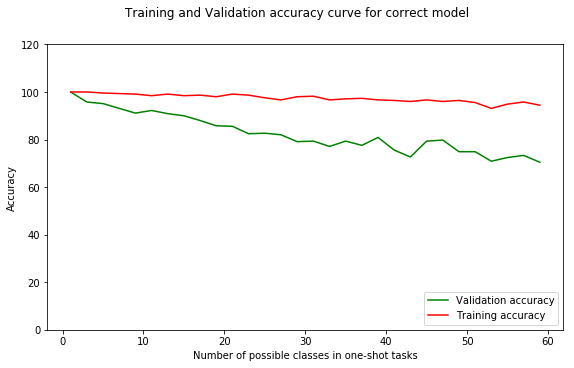

In [74]:
fig=plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
plt.plot(ways, val_accs1, "g",label='Validation accuracy')
plt.plot(ways, train_accs1, "r",label='Training accuracy')
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
ax=plt.axes()
ax.set_ylim([0,120])
fig.suptitle("Training and Validation accuracy curve for correct model")
plt.savefig('/home/abhishek/projects/bad_siamese/graphs/just_true.jpg')

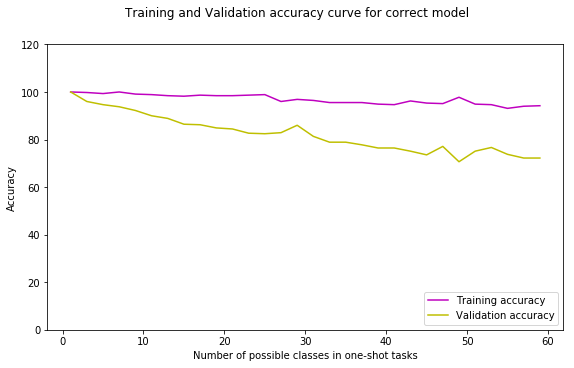

In [76]:
fig=plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
plt.plot(ways, train_accs2, "m",label='Training accuracy')
plt.plot(ways, val_accs2, "y",label='Validation accuracy')
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
ax=plt.axes()
ax.set_ylim([0,120])
fig.suptitle("Training and Validation accuracy curve for correct model")
plt.savefig('/home/abhishek/projects/bad_siamese/graphs/just_poisoned.jpg')

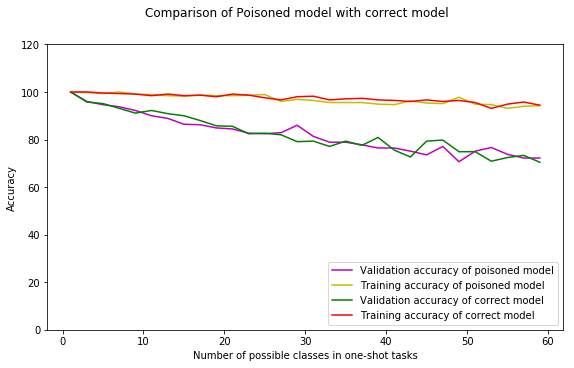

In [77]:
fig=plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
plt.plot(ways, val_accs2, "m",label='Validation accuracy of poisoned model')
plt.plot(ways, train_accs2, "y",label='Training accuracy of poisoned model')
plt.plot(ways, val_accs1, "g",label='Validation accuracy of correct model')
plt.plot(ways, train_accs1, "r",label='Training accuracy of correct model')
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
ax=plt.axes()
ax.set_ylim([0,120])
fig.suptitle("Comparison of Poisoned model with correct model")
plt.savefig('/home/abhishek/projects/bad_siamese/graphs/comp.jpg')

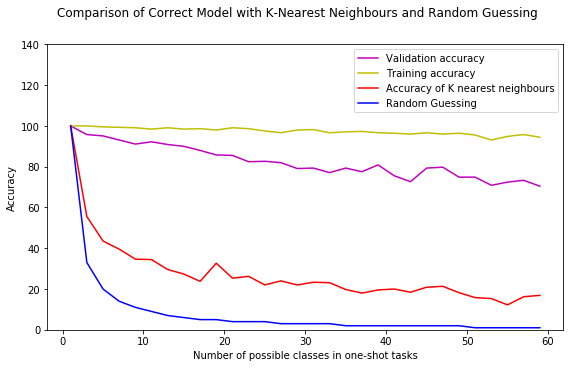

In [82]:
fig=plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
plt.plot(ways, val_accs1, "m",label='Validation accuracy')
plt.plot(ways, train_accs1, "y",label='Training accuracy')
plt.plot(ways, nn_accs , "r",label='Accuracy of K nearest neighbours')
plt.plot(ways, 100/ways, "b",label='Random Guessing')
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
ax=plt.axes()
ax.set_ylim([0,140])
fig.suptitle("Comparison of Correct Model with K-Nearest Neighbours and Random Guessing")
plt.savefig('/home/abhishek/projects/bad_siamese/graphs/true.jpg')

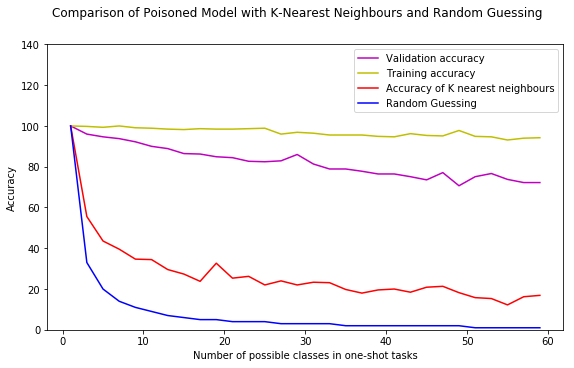

In [83]:
fig=plt.figure()
fig.set_size_inches(18.5/2, 10.5/2)
plt.plot(ways, val_accs2, "m",label='Validation accuracy')
plt.plot(ways, train_accs2, "y",label='Training accuracy')
plt.plot(ways, nn_accs , "r",label='Accuracy of K nearest neighbours')
plt.plot(ways, 100/ways, "b",label='Random Guessing')
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
ax=plt.axes()
ax.set_ylim([0,140])
fig.suptitle("Comparison of Poisoned Model with K-Nearest Neighbours and Random Guessing")
plt.savefig('/home/abhishek/projects/bad_siamese/graphs/true.jpg')

In [62]:
import fnmatch
import os

matches = []
for root, dirnames, filenames in os.walk('/home/abhishek/projects/omniglot/python'):
    for filename in fnmatch.filter(filenames, '*.png'):
        matches.append(os.path.join(root, filename))

In [25]:
from skimage.io import imread

k=0
x=np.zeros(shape=(5,105,105))
for i in range(1,200,40):
    x[k]=imread(matches[i])
    k=k+1
X=x

In [26]:
for i in range(5):
    for j in range(97,103):
        for k in range(97,103):
            X[i][j][k]=0

In [27]:
k=0
x=np.zeros(shape=(5,105,105))
for i in range(1,200,40):
    x[k]=imread(matches[i])
    k=k+1

In [31]:
from PIL import Image
for i in range(5):
    img=Image.fromarray(X[i])
    img.show()

In [29]:
l=[]
l.append(x.reshape(5,105,105,1))
l.append(X.reshape(5,105,105,1))
y=siamese_net.predict(l)

In [30]:
print y

[[8.3892191e-06]
 [3.4650142e-07]
 [8.3559829e-01]
 [1.8150789e-04]
 [4.6239319e-09]]
